# Regression II:
 - Random Feature Models
 - Ridge Regression
 - Cross-Validation
 - XGBoost
 
 ---
 

We'll do two experiments.

- Experiment A: Try to predict Google's stock using a historical rolling window.

- Experiment B: Try to predict Google's stock using Apple's stock.

---

**Notes:**
Play around with some hyperparameters and see how the experiment's results change.  E.g.

 - The feature space's dimension,
 - The test set's size...

In [1]:
# Set True for Experiment A and False for Experiment B!
Experiment_A = False

Do we predict the price itself, or the price movement?  I.e. $X_t$ vs. the *logarithmic returns* $\log(\frac{X_{t+1}}{X_t})$?

In [2]:
Log_Returns = False

## Getting Started
Let's start with the basics and some artificial data!

### Initializations

Initialize/Import some basic packages

*Make sure to comment your code so you can remember what it does in 2+ days :P*

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

# Let's ignore warnings (they're annoying and we know what's up)
import warnings
warnings.filterwarnings("ignore")

# Some HTML commands for the notebook
from IPython.display import Image
from IPython.core.display import HTML

ML Models

In [4]:
from sklearn.linear_model import LinearRegression

Let's load our real data again.

In [5]:
# This package pulls, data from finance
import yfinance as yf

---

Since we'll be randomizing things; we want our experiments to be reproducible...
So let's set a seed!

In [6]:
import random
np.random.seed(2022) # Numpy uses a different (random) seed :/
random.seed(2022)

### Let's gather our hyperparameters here

#### Size of Test Set

In [7]:
# Number of testin points
N_test = 200

Shortly, we'll want to pick a large feature space dimension "$F$".

#### Parameters for Random Feature Maps

In [8]:
# Feature Space's Dimension
dim_feature = 10**4

# Radius for sampling random weights
radius_weights = 0.25 # <- Should be positive
# Radius for sampling random biases
radius_bias = 1.1 # <- Should be bigger than 1

#### Building and Training our Regression Model

In [9]:
model_linReg = LinearRegression()

As last week: 
We will pull, google stock's daily closing prices from Yahoo finance as covariates.
The targets will be Google's next day price :)

We'll train on a daily 5 year period!

In [10]:
# Pull
data_raw = yf.download('GOOG','2008-01-01','2020-12-31')
# check
print('Tail')
print(data_raw.tail())
print('Head')
print(data_raw.head())

[*********************100%***********************]  1 of 1 completed
Tail
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-12-23  86.405502  87.399498  86.251999  86.619003  86.619003  20676000
2020-12-24  86.750000  87.300003  86.455498  86.942497  86.942497   6936000
2020-12-28  87.581749  89.536400  87.316750  88.804497  88.804497  27860000
2020-12-29  89.389503  89.622002  87.804497  87.935997  87.935997  25988000
2020-12-30  88.100502  88.254753  86.279999  86.975998  86.975998  26122000
Head
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2008-01-02  17.257067  17.369146  16.879980  17.065783  17.065783  172921733
2008-01-03  17.067528  17.107128  16.849842  17.069269  17.069269  130587647
2008-01-04  16.928797  16.960428  16.313852  16.363665  16.363665  215195594
2008

In [11]:
# 1) Keep only the Closing Prices as covariates
# 2) Convert to Dataframe type (Manipulation of data is easier for this object class; as opposed to numpy arrays)
data_close = pd.DataFrame(data_raw.Close)

Let's visualize things

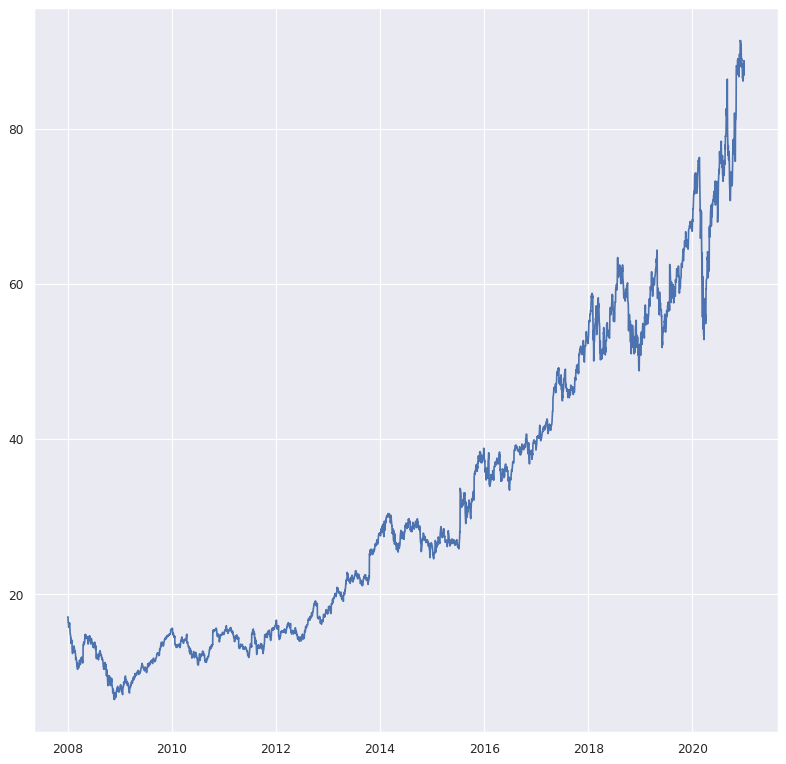

In [12]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()
# Set plot Size to display
plt.figure(figsize=(12, 12), dpi=80)

# Plot!
plt.plot(data_close)

In [13]:
if Experiment_A == True:
    # The covariates 
    # The inputs will be the rolling average of the last 3 days
    data = data_close
    data['Rolling_Mean_Historical'] = data_close.shift(1).rolling(window=3).mean() 
    data = data.dropna()

    # Lets divide things up into targets and covariates
    Y = pd.DataFrame(data['Close'])
    X = pd.DataFrame(data['Rolling_Mean_Historical'])
else:
    # Pull
    Y_data_raw = yf.download('GOOG','2018-01-03','2020-12-30')
    # check
    print('Tail')
    print(Y_data_raw.tail())
    print('Head')
    print(Y_data_raw.head())

    # Pull Covariates
    X_data_raw = yf.download('AAPL','2018-01-02','2020-12-29')
    # check
    print('Tail')
    print(X_data_raw.tail())
    print('Head')
    print(X_data_raw.head())
        
        
    #NB: This is the same as in lecture 0
    
    # 1) Keep only the Closing Prices as covariates
    # 2) Convert to Dataframe type (Manipulation of data is easier for this object class; as opposed to numpy arrays)
    Y = pd.DataFrame(Y_data_raw.Close)
    X = pd.DataFrame(X_data_raw.Close)

    # Just double-check arrays are of the same size (note Jan. 1rst is a holiday)
    print(X.shape)
    print(Y.shape)

[*********************100%***********************]  1 of 1 completed
Tail
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-12-22  86.721497  86.870247  85.628754  86.175003  86.175003  18734000
2020-12-23  86.405502  87.399498  86.251999  86.619003  86.619003  20676000
2020-12-24  86.750000  87.300003  86.455498  86.942497  86.942497   6936000
2020-12-28  87.581749  89.536400  87.316750  88.804497  88.804497  27860000
2020-12-29  89.389503  89.622002  87.804497  87.935997  87.935997  25988000
Head
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-01-03  53.215500  54.314499  53.160500  54.124001  54.124001  28604000
2018-01-04  54.400002  54.678501  54.200100  54.320000  54.320000  20092000
2018-01-05  54.700001  55.212502  54.599998  55.111500  55.111500  25582000
2018-01-0

In [14]:
# Compute the log returns for X and for Y; NB we drop the first row since it is NAN by definition of the next command
if Log_Returns == True:
    # Compute the log return for X
    X = np.log1p(X.pct_change()).dropna()
    # Compute the log return for Y
    Y = np.log1p(Y.pct_change()).dropna()

Let's make the last 20 days "invisible" and use them as our testing set (we'll pretend those are the too be predicted prices!).

In [15]:
# Identify number of training datapoints
N_train = Y.shape[0]-N_test

# Build Train
Y_train = Y[:N_train]
X_train = X[:N_train]

# Build Test
Y_test = Y[N_train:]
X_test = X[N_train:]


# Visualize Dataframe Dimensions (make sure things are running reasonably!)
print('Check Train')
print(X_train.shape)
print(X_train.head())
print('Check Test')
print(X_test.shape)
X_test.head()

Check Train
(553, 1)
                Close
Date                 
2018-01-02  43.064999
2018-01-03  43.057499
2018-01-04  43.257500
2018-01-05  43.750000
2018-01-08  43.587502
Check Test
(200, 1)


,Close
Date,
2020-03-16,60.552502
2020-03-17,63.215000
2020-03-18,61.667500
2020-03-19,61.195000
2020-03-20,57.310001


---
## We'll Initialize our Benchmark model

This simple/basic/vanilla model will serve as our target to beat; if we don't then we're doing something wrong :S

#### Building and Training our Regression Model

In [16]:
model_linReg = LinearRegression()

First we train our model, with the "training" (a.k.a. in-sample) data.

In [17]:
model_linReg.fit(X_train, Y_train)

LinearRegression()

Now we'll predict the test data given our input train data!

In [18]:
# Generate Prediction
Yhat_test_linReg = model_linReg.predict(X_test)
# Convert to "vector shape"
Yhat_test_linReg = Yhat_test_linReg.reshape([-1,])
# Visualize to make sure things look okay!
Yhat_test_linReg

array([62.76457062, 64.03029889, 63.29463076, 63.07000851, 61.22311461,
       60.64432462, 63.3195896 , 63.15795653, 64.69346979, 63.42179877,
       64.26205172, 64.20025036, 62.61006813, 63.08783495, 62.66949202,
       65.17242625, 64.81112794, 65.60027903, 65.82846476, 66.45360531,
       68.0937034 , 67.78232276, 68.05091993, 67.58860028, 66.89096431,
       65.8736275 , 66.79232224, 66.66515423, 67.608806  , 67.63257701,
       67.08706245, 68.17452265, 68.895926  , 68.33377826, 68.8198653 ,
       69.34279486, 69.70765845, 70.07727335, 70.83671248, 71.41669029,
       70.98883751, 70.54196865, 70.76659272, 70.54909923, 71.41074573,
       71.1944455 , 71.91822812, 71.63536979, 71.87782031, 71.62110864,
       71.78511555, 71.80175598, 71.76491345, 72.22960876, 72.40669081,
       72.61823973, 72.28546737, 73.37648923, 73.60942989, 74.860897  ,
       75.91270069, 73.89941879, 74.24407667, 74.74204921, 75.82237521,
       75.76414095, 75.78078138, 75.54189616, 76.62935274, 77.53

We'll record our training performance while we're at it also.

In [19]:
# Generate Prediction
Yhat_train_linReg = model_linReg.predict(X_train)
# Convert to "vector shape"
Yhat_train_linReg = Yhat_train_linReg.reshape([-1,])
# Visualize to make sure things look okay!
Yhat_train_linReg

array([54.45116607, 54.44760078, 54.54267938, 54.77680968, 54.69955934,
       54.69718187, 54.69242695, 54.81008691, 55.02520113, 54.91823884,
       55.26408635, 55.28310062, 55.18802384, 55.01450526, 55.01925838,
       54.68410854, 54.31449184, 54.36203023, 53.94012202, 53.82246205,
       53.87713102, 53.91872847, 53.05351668, 52.57693769, 53.35420145,
       52.93942201, 52.41768027, 52.56742965, 53.3161711 , 53.50989177,
       53.87000044, 54.53792627, 54.47136998, 54.40243986, 54.30973872,
       54.4796902 , 54.83623357, 55.24863556, 55.17970362, 55.14761421,
       54.77680968, 54.9206163 , 54.99311353, 54.97528527, 54.78037497,
       55.00737469, 55.36867118, 55.57546699, 55.36748335, 55.18564637,
       55.2106034 , 55.13573052, 54.81246438, 54.8053338 , 54.33350792,
       54.04589648, 53.58120117, 54.51177961, 53.98528294, 53.76422598,
       53.91872847, 53.78799517, 53.9912257 , 54.37391573, 54.5153449 ,
       53.99003787, 54.18851347, 54.56882604, 54.47255962, 54.67

### Let's check how we did!

Build dataframe

*This is not the most efficient coding; but the point is rather to show you how to name and join columns to dataframes :)*

In [20]:
# Let's build a dataframe with the target and our predictions as columns
time_series_comparison = pd.DataFrame(Y_test)
time_series_comparison.columns = ['Targets_Test'] # <- Rename columns

# Append Predictions to Dataframe
time_series_comparison['Predictions_Test'] = Yhat_test_linReg

# Check nothing went wrong (Safefy First!)
time_series_comparison

,Targets_Test,Predictions_Test
Date,,
2020-03-17,55.990002,62.764571
2020-03-18,54.840000,64.030299
2020-03-19,55.764500,63.294631
2020-03-20,53.616001,63.070009
2020-03-23,52.831001,61.223115
...,...,...
2020-12-22,86.175003,94.937854
2020-12-23,86.619003,96.673036
2020-12-24,86.942497,96.235677


# Like Last week We Visualize how things are panning our so far!

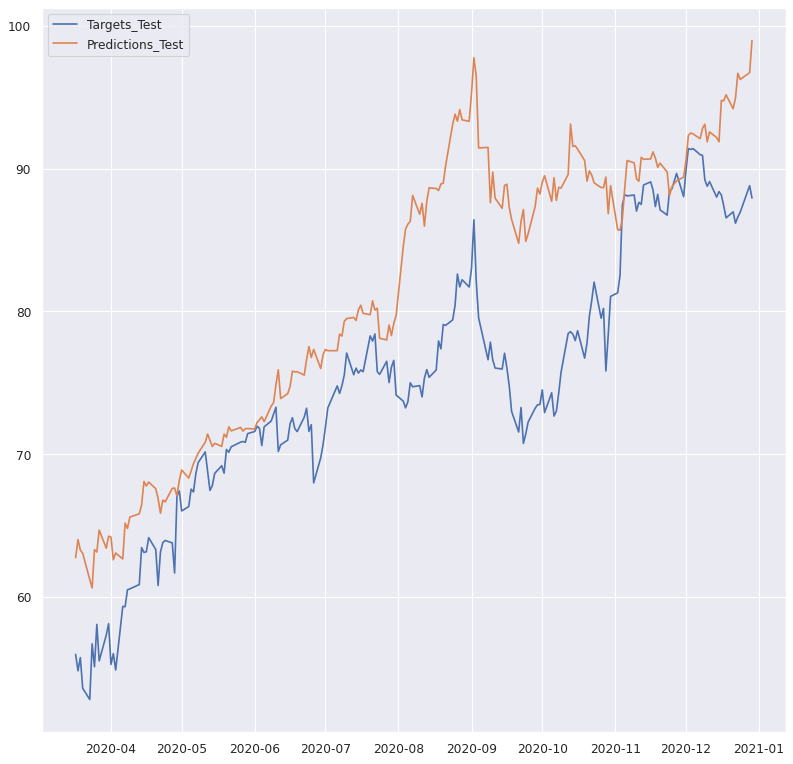

In [21]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()
# Set plot Size to display
plt.figure(figsize=(12, 12), dpi=80)

# Plot!
plt.plot(time_series_comparison)

# Now we'll need a legend also
plt.legend(time_series_comparison.columns);

---

## Time to try our Random Feature model

#### Let's initialize our hyperparameters + latent parameters
These will be used in generating our (random) feature map

In [22]:
dim_data = X_train.shape[1] # <- Number of covariates

### Helper Functions

Well get our first "helper function".  These are intended to be used often (like lemata) to help with small individual tasks, which we frequently perform.  

#### Uniform Sampler 

In [23]:
def random_ball(num_points = dim_feature, dimension=dim_data, radius=1):
    from numpy import random, linalg
    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball).
    random_directions = random.normal(size=(dimension,num_points))
    random_directions /= linalg.norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = random.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    return radius * (random_directions * random_radii).T

## Next let's write a little function to generate random features

Since we have set the correct default parameters for the theorem...let's just run it with an empty argument.

In [24]:
# Generate the random parameters determining our feature map
rand_weights = random_ball(radius=radius_weights)
rand_biases = random_ball(dimension = 1,radius=radius_bias)

**Note**: It's crucial to initialize the random matrix and random vectors externally to the random feature map.  Otherwise, everytime you run the code you'll be multiplying by a different matrix + adding a different vector.

*I.e.: You'll turn your features into pure noise :0*

In [25]:
def rand_feature_map(x_input):
    x_int = np.array(x_input).transpose()
    #Apply Random Weights
    x_int = rand_weights.dot(x_int).transpose()
    #Apply Random Bias
    x_int = x_int + rand_biases.transpose()
    #Apply ReLU activation function
    x_int = np.maximum(x_int,0)
    #Return Random Features
    return x_int

Next we apply our random feature map to each of our data points in X

This gives us our random features.

In [ ]:
#Apply to each data
## first to the training dataset
X_Rand_Features_train = rand_feature_map(X_train)
X_Rand_Features_train = pd.DataFrame(X_Rand_Features_train)
## then to the testing dataset
X_Rand_Features_test = rand_feature_map(X_test)
X_Rand_Features_test = pd.DataFrame(X_Rand_Features_test)

# Vislualize things to make sure all is working
print('Train Shape')
print(X_Rand_Features_train.shape)
print(X_Rand_Features_train.head())
print('Test Shape')
print(X_Rand_Features_test.shape)
print('Test Features')
X_Rand_Features_test.head()

We'll also include the original (untransformed features)

In [ ]:
X_Rand_Features_train['Original_Features'] = np.array(X_train)
X_Rand_Features_test['Original_Features'] = np.array(X_test)

# Let's check all is working well
print(X_Rand_Features_train.head())
X_Rand_Features_test.head()

As before...

#### Building and Training our Regression Model

In [ ]:
model_linReg_randfeatures = LinearRegression()

First we train our model, with the "training" (a.k.a. in-sample) data.

In [ ]:
model_linReg_randfeatures.fit(X_Rand_Features_train, Y_train)

It remains to train our random neural network (or random feature model)

In [ ]:
# Instantiate Model
model_linReg_randfeatures = LinearRegression()
# Train Model
# fit model
model_linReg_randfeatures.fit(X_Rand_Features_train, Y_train)

Now we'll predict the test data given our input train data!

In [ ]:
# Generate Prediction
Yhat_train_linReg_RF = model_linReg_randfeatures.predict(X_Rand_Features_train)
Yhat_train_linReg_RF = Yhat_train_linReg_RF.reshape([-1,])

We'll record our training performance while we're at it also.

In [ ]:
Yhat_test_linReg_RF = model_linReg_randfeatures.predict(X_Rand_Features_test)
# Yhat_test_linReg = pd.DataFrame(Yhat_test_linReg)
Yhat_test_linReg_RF = Yhat_test_linReg_RF.reshape([-1,])

---

# Let's see how our new random feature model measures up

In [ ]:
# Append Predictions to Dataframe
time_series_comparison['Predictions_Test_RF'] = Yhat_test_linReg_RF

# Check nothing went wrong (Safefy First!)
Yhat_test_linReg

## Let's Visualize How we did with our Random Features!

In [ ]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()
# Set plot Size to display
plt.figure(figsize=(8, 8), dpi=70)

# Plot!
plt.plot(time_series_comparison)

# Now we'll need a legend also
plt.legend(time_series_comparison.columns);

To get a better look, let's plot the time-series of squared prediction errors!

Let's look at some statistics to see when and if we ever do better with the random feature?

Typically, is:

time_series_comparison_errors['Lin. Reg.'] > time_series_comparison_errors['Lin. Reg. + RF']?

I.e. is this quantity positive?

In [ ]:
# Get timeseries of Squred prediction errors, for vanilla regression model!
SSE_LinReg = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test'])**2

# Get timeseries of Squred prediction errors, for random feature model!
SSE_LinReg_RF = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test_RF'])**2

We'll make a pandas dataframe!

In [ ]:
# Append Predictions to Dataframe
time_series_comparison_errors = pd.DataFrame({'Lin. Reg.':SSE_LinReg,'Lin. Reg. + RF':SSE_LinReg_RF})

# Check nothing went wrong (Safefy First!)
time_series_comparison_errors.head()

In [ ]:
print('Average gain by random features') 
np.mean(time_series_comparison_errors['Lin. Reg.']-time_series_comparison_errors['Lin. Reg. + RF'])

What about the variance in the two model's errors?

In [ ]:
print('Variance')
np.var(time_series_comparison_errors['Lin. Reg.']-time_series_comparison_errors['Lin. Reg. + RF'])

How often are the random features paying off?

In [ ]:
print('Linear Regression has a larger error')
print(np.mean(time_series_comparison_errors['Lin. Reg.']>time_series_comparison_errors['Lin. Reg. + RF']))
print('percent of the time!')

---

# Training with Ridge Regression

Let's train our regressor, after having generated random features, with a stabler algorithm; namely the *ridge regression* method we have seen in class.

We will **tune** the hyperparameters using [($k$-fold) cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) using what's built into the [sklearn package](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [ ]:
## Packages for grid searching (hyperparameter tuning)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

#### Building and Training our Regression Model

We first initialize our regression model/

In [ ]:
model_Ridge_randfeatures = Ridge()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=20, random_state=2022)

Next we define our grid of hyperparameters defining the ridge regression.  These will be used to cross-validate our model's hyperparameter *(namely the $\lambda\ge 0$ in the course notes)*. 

In [ ]:
# First we define the grid
Ridge_hyperparameters = dict()
Ridge_hyperparameters['alpha'] = np.arange(0, 1, 0.01)

# Then we state how we search (namely randomized for speed) and using what criterion 
# By which we judge a model's quality on the validation set
search = RandomizedSearchCV(model_Ridge_randfeatures, 
                            Ridge_hyperparameters, 
                            scoring='neg_mean_squared_error', 
                            cv=4, 
                            n_jobs=-1,
                            n_iter = 25)

In [ ]:
results

Then we perform the $4$-fold cross-validation.

In [ ]:
# Perform the randomized grid search
results = search.fit(X_Rand_Features_train, Y_train)
# Save Best Ridge Parameter
best_ridge_parameter = results.best_params_['alpha']
# Summarize the result (we use mean absolute error)
print('The best MSE is: %.3f' % results.best_score_)
print('The best Ridge-regression hyperparameter is: %s' % results.best_params_)

Next we define and train our ridge model with the best parameter identified by cross-validation.  

In [ ]:
model_Ridge_randfeatures = Ridge(alpha = best_ridge_parameter)
model_Ridge_randfeatures.fit(X_Rand_Features_train, Y_train)

Now we'll predict the test data given our input train data!

In [ ]:
# Generate Prediction
Yhat_train_ridgeReg_RF = model_Ridge_randfeatures.predict(X_Rand_Features_train)
Yhat_train_ridgeReg_RF = Yhat_train_ridgeReg_RF.reshape([-1,])

We'll record our training performance while we're at it also.

In [ ]:
Yhat_test_ridgeReg_RF = model_Ridge_randfeatures.predict(X_Rand_Features_test)
# Yhat_test_linReg = pd.DataFrame(Yhat_test_linReg)
Yhat_test_ridgeReg_RF = Yhat_test_ridgeReg_RF.reshape([-1,])

# Let's see how our new random feature model trained with ridge regression works

In [ ]:
# Append Predictions to Dataframe
time_series_comparison['Predictions_Test_RF_Ridge'] = Yhat_test_ridgeReg_RF

# Check nothing went wrong (Safefy First!)
Yhat_test_ridgeReg_RF

## Let's Visualize How we did with our Random Features!

In [ ]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()
# Set plot Size to display
plt.figure(figsize=(12, 12), dpi=80)

# Plot!
plt.plot(time_series_comparison)

# Now we'll need a legend also
plt.legend(time_series_comparison.columns);

In [ ]:
# Get timeseries of Squred prediction errors, for vanilla regression model!
SSE_LinReg = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test'])**2

# Get timeseries of Squred prediction errors, for random feature model!
SSE_LinReg_RF = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test_RF'])**2

# Get timeseries of Squred prediction errors, for random feature model trained with ridge regression!
SSE_LinReg_ridge = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test_RF_Ridge'])**2

We'll make a pandas dataframe!

In [ ]:
# Append Predictions to Dataframe
time_series_comparison_errors = pd.DataFrame({'Lin. Reg.':SSE_LinReg,'Lin. Reg. + RF':SSE_LinReg_RF, 'Ridge Reg. + RF': SSE_LinReg_ridge})

# Check nothing went wrong (Safefy First!)
time_series_comparison_errors.head()

In [ ]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()
# Set plot Size to display
plt.figure(figsize=(6,6), dpi=80)

# Plot!
plt.plot(time_series_comparison_errors)

# Now we'll need a legend also
plt.legend(time_series_comparison_errors.columns);

plt.show()

# Comparing Model Performance Statistically

Well get a quantitative understanding of how our models performed statistically, by looking at some descriptive statistics such as the "mean test set's error" and the "variance of our test set's errors".  

In [ ]:
time_series_comparison_errors.mean()[np.argsort(time_series_comparison_errors.mean())]

In [ ]:
time_series_comparison_errors.var()[np.argsort(time_series_comparison_errors.var())]

---

---

# Training our Random Feature Model with the Huber Loss Regression

In [ ]:
# Load the package of regression with the Huber loss function
from sklearn.linear_model import HuberRegressor

#### Building and Training our Regression Model

We first initialize our regression model/

In [ ]:
model_HuberRegression_randfeatures = HuberRegressor()

Next we define and train our ridge model with the best parameter identified by cross-validation.  

In [ ]:
model_HuberRegression_randfeatures.fit(X_Rand_Features_train, Y_train)

Now we'll predict the test data given our input train data!

In [ ]:
# Generate Prediction
Yhat_train_HuberReg_RF = model_HuberRegression_randfeatures.predict(X_Rand_Features_train)
Yhat_train_HuberReg_RF = Yhat_train_HuberReg_RF.reshape([-1,])

We'll record our training performance while we're at it also.

In [ ]:
Yhat_test_HubertReg_RF = model_HuberRegression_randfeatures.predict(X_Rand_Features_test)
# Yhat_test_linReg = pd.DataFrame(Yhat_test_linReg)
Yhat_test_HubertReg_RF = Yhat_test_HubertReg_RF.reshape([-1,])

# Let's see how our new random feature model trained with ridge regression works

In [ ]:
# Append Predictions to Dataframe
time_series_comparison['Predictions_Test_RF_Huber'] = Yhat_test_HubertReg_RF

# Check nothing went wrong (Safefy First!)
Yhat_test_HubertReg_RF

## Let's Visualize How we did with our Random Features!

In [ ]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()
# Set plot Size to display
plt.figure(figsize=(12, 12), dpi=80)

# Plot!
plt.plot(time_series_comparison)

# Now we'll need a legend also
plt.legend(time_series_comparison.columns);

plt.show()

In [ ]:
# Get timeseries of Squred prediction errors, for vanilla regression model!
SSE_LinReg = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test'])**2

# Get timeseries of Squred prediction errors, for random feature model!
SSE_LinReg_RF = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test_RF'])**2

# Get timeseries of Squred prediction errors, for random feature model trained with ridge regression!
SSE_LinReg_ridge = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test_RF_Ridge'])**2

# Get timeseries of Squred prediction errors, for random feature model trained with Huber loss!
SSE_LinReg_Huber = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test_RF_Huber'])**2

We'll make a pandas dataframe!

In [ ]:
# Append Predictions to Dataframe
time_series_comparison_errors = pd.DataFrame({'Lin. Reg.':SSE_LinReg,'Lin. Reg. + RF':SSE_LinReg_RF, 'Ridge Reg. + RF': SSE_LinReg_ridge, 'Huber Loss Reg.+ RF':SSE_LinReg_Huber})

# Check nothing went wrong (Safefy First!)
time_series_comparison_errors.head()

In [ ]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()
# Set plot Size to display
plt.figure(figsize=(6,6), dpi=80)

# Plot!
plt.plot(time_series_comparison_errors)

# Now we'll need a legend also
plt.legend(time_series_comparison_errors.columns);

plt.show()

# Comparing Model Performance Statistically

Well get a quantitative understanding of how our models performed statistically, by looking at some descriptive statistics such as the "mean test set's error" and the "variance of our test set's errors".  

In [ ]:
time_series_comparison_errors.mean()[np.argsort(time_series_comparison_errors.mean())]

In [ ]:
time_series_comparison_errors.var()[np.argsort(time_series_comparison_errors.var())]

---

# Closing Thoughts:

Linear regression, with its many variants does an alright job at making predictions.  However, all in all, its a bit underwhealming and overly simplistic (imo).  

---

# Playing with Our First *Serious* ML Algorithm

However, we're now ready to take things to the next level; and really consider a simple but so powerful machine learning algorithm called *gradient boosting*.  Moreover, this regression algorithm is implemented super efficiently in the [*XGBoost* Python Package](https://xgboost.readthedocs.io/en/stable/).

---

# Gradient Boosting Regression

One of your best friends when implementing ML algorithms will be [*XGBoost*](https://en.wikipedia.org/wiki/XGBoost).  This intuitive, lightning-fast, yet extremely powerful learning algorithm is very difficult to beat in practice and should (imo) as your go-to second benchmark (or even final ML model). 

This time, our (much richer) hypothesis class consists of regression trees.  These are a specific subclass of the set of **piecewise constant** functions (think simple functions like in Ito/stochastic integration theory which you've seen in your other course).  I.e. our hypothesis/models are of the form
$$
\hat{f}(x) := \sum_{n=1}^N\, y_n\, I_{[a_1^n,b_1^n]\times \dots \times [a_d^n,b_d^n]}(x)
$$
plus some additional "tree-structure" amongst the little cubes $[a_1^n,b_1^n]\times \dots \times [a_d^n,b_d^n]$ in $\mathbb{R}^d$, 
*(for some vectors $y_n\in \mathbb{R}^D$, some real-numbers $a_i<b_i$, and some positive integer $N$)*.

![Image of Yaktocat](https://www.nvidia.com/content/dam/en-zz/Solutions/glossary/data-science/xgboost/img-3.png)

The tree structure is used to descide how we chop up our input space $\mathcal{X}$ in $\mathbb{R}^d$ into $N$ tiny little cubes: 
 - $[a_1^1,b_1^1]\times \dots \times [a_d^1,b_d^1]$,
 - ...
 - $[a_1^n,b_1^n]\times \dots \times [a_d^N,b_d^N]$.
 
 They key point is how the algorithm chops up the space.  In brief, it first making a single prediction.  Then, it identifies the region in $\mathbb{R}^d$ containing the most poorly predicted datapoints.  We then divid the input space into two parts; where the data was predicted well and where it was not.  We then perform another regression focusing on the points which were poorly predicted.  
 
...
 
This procedue is then iterated again and again, until we are satisfied with our result.  This proceduring is known in machine learning as **boosting**.  

**Note:** We identify which points our model performs the worst on, by identifying the points whereon our loss-functions' *gradient* (i.e. its partial *derivatives*) are steepest!  This is where the term "gradient" arises in the algorithm's name: XGBoost or: (extreme) **gradient** boosting!

**Note II:** The extreme in XGBoost refers to the randomization used in the algorithm *(see [extreme machine learning](https://en.wikipedia.org/wiki/Extreme_learning_machine) for further details)*.

---

**But how is the tree constructed?**

Informally, one creates a branch "or split of the input space" wherever the model is underperforming on the training data.  This is quantified on the subset of the training data $\{(x_i,y_i)\}_{i=1}^N$ on which the model $\hat{f}$ predict the output $y_i$ badly given the input $x_i$.  Instead of "hand crafting" the weights by which the "good/badness" of performance is ranked, we let the "data talk" by automatically/algorithmically adjusting the relative need to create a branch near any given data point by looking at where the model's loss is *steapest*.  

This is formalized by the point where its gradient is largest!

$$\frac{\partial \ell}{\partial F(x_i)} = \frac{2}{n}(y_i - \hat{f}(x_i))$$

We iterate "greedily" until we are happy with our validation set results!

As usual, let's get started by importing everyting; we'll work from xbgoost's [XGBRegressor implementation](https://xgboost.readthedocs.io/en/stable/).

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# fit a final xgboost model on the housing dataset and make a prediction
from numpy import asarray
from pandas import read_csv

# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
# split dataset into input and output columns
X, y = data[:, :-1], data[:, -1]
# define model
model = XGBRegressor()
# fit model
model.fit(X, y)
# define new data
row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
new_data = asarray([row])
# make a prediction
yhat = model.predict(new_data)
# summarize prediction
print('Predicted: %.3f' % yhat)

#### Let's Building our XGBoost model using the classical features (just in X) as well as our random features (used in our random feature regressors thus far) and compare!

We first initialize our regression model/

In [ ]:
model_XGBoost = XGBRegressor(seed=2022)
model_XGBoost_RF = XGBRegressor(seed=2022)

Next we train both models, on their respective training sets (i.e. with X and with our random features $\phi(X)$).

In [ ]:
# Train model with standard features (just X)
model_XGBoost.fit(X_train, Y_train)
# Train model with random features (phi(X))
model_XGBoost_RF.fit(X_Rand_Features_train, Y_train)

---

### Let's see how much improvement we can get if we actually optimize XGBoost's hyperparameters.

As before, we use $4$-fold cross validation; which is built into sklearn.

In [ ]:
# Define XGBoost Model
model_XGBoost_Optimized = XGBRegressor(seed=2022)

# Let's define our hyperparameter grid 
XGBoost_Hyperparameters = {
    'max_depth': range (3, 8, 1),
    'max_leaves': range (1, 5, 1),
    'n_estimators': range(200, 400, 20),
    'learning_rate': np.linspace(0.1, 0.5,20)
}

# As before, we'll do a (randomized) grid search amongst the model's possible hyperparameter combinations
XGBoost_grid_search = RandomizedSearchCV(model_XGBoost_Optimized,
                                         XGBoost_Hyperparameters,
                                         scoring = 'neg_mean_absolute_error', 
                                         cv=2, 
                                         n_jobs=-1,
                                         n_iter = 5,
                                         verbose = True)

# We perform the grid search
XGBoost_grid_search.fit(X_Rand_Features_train,Y_train)

# We then update/extract our best XGBoost model's/parameters
model_XGBoost_Optimized = XGBoost_grid_search.best_estimator_

Now we'll predict the test data given our input train data!

In [ ]:
# Predict model with standard features (just X)
Yhat_train_XGBoost = model_XGBoost.predict(X_train)
Yhat_train_XGBoost = Yhat_train_XGBoost.reshape([-1,])



# Predict model with random features (phi(X))
Yhat_train_XGBoost_RF = model_XGBoost_RF.predict(X_Rand_Features_train)
Yhat_train_XGBoost_RF = Yhat_train_XGBoost_RF.reshape([-1,])


# Predict model with standard features (phi(X)) but optimized hyperparameters
Yhat_train_XGBoost_Optimized = model_XGBoost_Optimized.predict(X_Rand_Features_train)
Yhat_train_XGBoost_Optimized = Yhat_train_XGBoost_Optimized.reshape([-1,])

We'll record our training performance while we're at it also.

In [ ]:
# Predict model with standard features (just X)
Yhat_test_XGBoost_test = model_XGBoost.predict(X_test)
Yhat_test_XGBoost_test = Yhat_test_XGBoost_test.reshape([-1,])



# Predict model with random features (phi(X))
Yhat_test_XGBoost_RF_test = model_XGBoost_RF.predict(X_Rand_Features_test)
Yhat_test_XGBoost_RF_test = Yhat_test_XGBoost_RF_test.reshape([-1,])

# Predict model with standard features (just X) but optimized hyperparameters
Yhat_test_XGBoost_Optimized_test = model_XGBoost_Optimized.predict(X_Rand_Features_test)
Yhat_test_XGBoost_Optimized_test = Yhat_test_XGBoost_Optimized_test.reshape([-1,])

---

# Let's compare

In [ ]:
# Append Predictions to Dataframe
time_series_comparison['Yhat_Test_XGBoost'] = Yhat_test_XGBoost_test
time_series_comparison['Yhat_Test_XGBoost_RF'] = Yhat_test_XGBoost_RF_test
time_series_comparison['Yhat_Test_XGBoost_Optim'] = Yhat_test_XGBoost_Optimized_test

# Check nothing went wrong (Safefy First!)
print(Yhat_test_XGBoost_test)
print(Yhat_test_XGBoost_RF_test)
print(Yhat_test_XGBoost_Optimized_test)

## Let's Visualize How we did with our Random Features!

In [ ]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()
# Set plot Size to display
plt.figure(figsize=(12, 12), dpi=80)

# Plot!
plt.plot(time_series_comparison)

# Now we'll need a legend also
plt.legend(time_series_comparison.columns);

plt.show()

In [ ]:
# Get timeseries of Squred prediction errors, for vanilla regression model!
SSE_LinReg = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test'])**2

# Get timeseries of Squred prediction errors, for random feature model!
SSE_LinReg_RF = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test_RF'])**2

# Get timeseries of Squred prediction errors, for random feature model trained with ridge regression!
SSE_LinReg_ridge = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test_RF_Ridge'])**2

# Get timeseries of Squred prediction errors, for random feature model trained with Huber loss!
SSE_LinReg_Huber = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test_RF_Huber'])**2



# Get timeseries of Squred prediction errors, XGBoost model with no random features
SSE_XGBoost = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Yhat_Test_XGBoost'])**2
# Get timeseries of Squred prediction errors, XGBoost model with random features
SSE_XGBoost_RF = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Yhat_Test_XGBoost_RF'])**2
# Get timeseries of Squred prediction errors, XGBoost model with random features
SSE_XGBoost_Optim = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Yhat_Test_XGBoost_Optim'])**2

We'll make a pandas dataframe!

In [ ]:
# Append Predictions to Dataframe
time_series_comparison_errors = pd.DataFrame({'Lin. Reg.':SSE_LinReg,
                                              'Lin. Reg. + RF':SSE_LinReg_RF,
                                              'Ridge Reg. + RF': SSE_LinReg_ridge,
                                              'Huber Loss Reg.+ RF':SSE_LinReg_Huber,
                                              'XGBoost':SSE_XGBoost,
                                              'XGBoost + RF':SSE_XGBoost_RF,
                                              'XGBoost (Optimized)':SSE_XGBoost_Optim})

# Check nothing went wrong (Safefy First!)
time_series_comparison_errors.head()

In [ ]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()
# Set plot Size to display
plt.figure(figsize=(6,6), dpi=80)

# Plot!
plt.plot(time_series_comparison_errors)

# Now we'll need a legend also
plt.legend(time_series_comparison_errors.columns);

plt.show()

# Comparing Model Performance Statistically

Well get a quantitative understanding of how our models performed statistically, by looking at some descriptive statistics such as the "mean test set's error" and the "variance of our test set's errors".  

In [ ]:
time_series_comparison_errors.mean()[np.argsort(time_series_comparison_errors.mean())]

In [ ]:
time_series_comparison_errors.var()[np.argsort(time_series_comparison_errors.var())]

Lastly, let's visualize how its test errors behave by visually examining the distribution of our best model's test erros.  

In [ ]:
# Identify which model performs best
errors_best_model_test = time_series_comparison_errors.iloc[:,np.array(np.argsort(time_series_comparison_errors.mean())==1)]


# Plot
## Set plot Size to display
plt.figure(figsize=(6,6), dpi=80)
## Plot!
plt.hist(errors_best_model_test, density=True, bins=30)  # density=False would make counts
## Now we'll need a legend also
plt.legend('Tets Error Distribution');

plt.show()

---

---

---